## Task 1
### Cory Wilson

### Initial Imports and DataFrame Creation

In [178]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

#create a dataframe from teleco_time_series.csv
df = pd.read_csv('teleco_time_series.csv')
df.head

<bound method NDFrame.head of      Day    Revenue
0      1   0.000000
1      2   0.000793
2      3   0.825542
3      4   0.320332
4      5   1.082554
..   ...        ...
726  727  16.931559
727  728  17.490666
728  729  16.803638
729  730  16.194813
730  731  16.620798

[731 rows x 2 columns]>

## Part I: Research Question

### A.1. Research Question

Time series analysis is a method of analyzing time series data. It can be utilized in a varitey of situations and is often used to predict future values using previous values. In terms of this data set we are interested in predicting future revenue based on the past revenue.

The question we will be answering is: Can future revenue be predicted based on the past revenue and is it accurate?

### A.2. Data Analysis Goals

The main goal of this analysis is to generate a forecast for future revenue that is accurate. This can allow the business to better plan for increased or decreased sales.

## Part II: Method Justification

### B. Assumptions

There are many assumptions that must be satisfied when dealing with time series data. 

- Stationarity - One of the main assumptions is that the series is stationary. This means that the mean and variance should remain constant over long periods of time.
- Outliers - Another assumption is that the data itself should contain no outliers.
- Autocorrelation - Autocorrelation is defined as a time series being related to a lagged version of itself.

## Part III: Data Preparation

### C.1. Line Graph

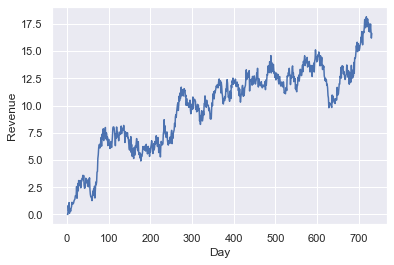

In [179]:
#plot the data with seaborn
sns.set(style="darkgrid")
sns.lineplot(x='Day',y='Revenue', data=df)
plt.show()

### C.2. Time Step Formatting

The code blocks below describe the data, check for any gaps or missing values, and check the length of the time series.

In [180]:
# Describe the data
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [181]:
# Missing values or gaps in the data
df.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [182]:
df.isna().sum()

Day        0
Revenue    0
dtype: int64

In [183]:
length_of_time_series = len(df)
F"The length of the time series is {length_of_time_series} days."

'The length of the time series is 731 days.'

### C.3. Stationarity

In [184]:
adftest= ADFTest(alpha=0.05)
adftest.should_diff(df.Revenue)

(0.024309594549729075, False)

### The PMDArima package provides a tool to check for stationarity. The code ran above shows that our data is not stationary.

### C.4. Steps

- Create a pandas dataframe from the available CSV file.
- View summary statistics using describe function
- Check for missing or incomplete values in the data
- Split the data using test train split. (Included in section below)

### C.5. Cleaned Data Set

Below we split the dataframe in to train and test subsets.

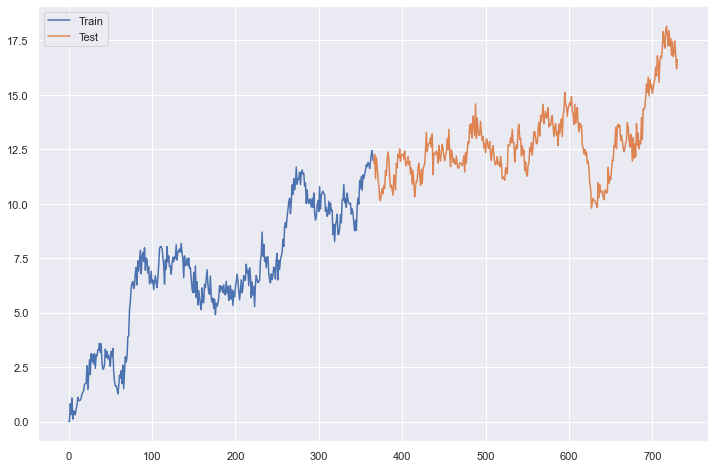

In [185]:
df_train = df.iloc[:len(df)-365]
df_test = df.iloc[len(df)-365:]

# Plot the split data side by side
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_train.Revenue, label='Train')
ax.plot(df_test.Revenue, label='Test')
ax.legend()
plt.show()

The cleaned dataframe is being output as a CSV file below.

In [186]:
# Convert data frame to CSV
df.to_csv('Cleaned_data.csv', index=False)

## Part IV: Model Identification and Analysis

### D.1. Findings and Visualizations

## Seasonal Decompisition

A seasonal decompisition is the quickest way to check for seasonality, trends, and residual trends.

### Presence of a seasonal component
From the charts below, we can easily see that seasonality exists.

### Trends
The decompisition shows that their is a gradual trend upward over time.

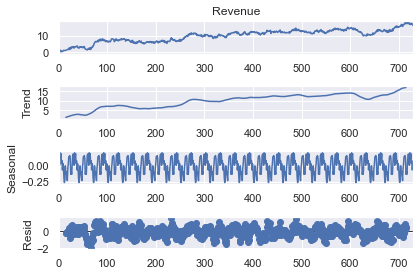

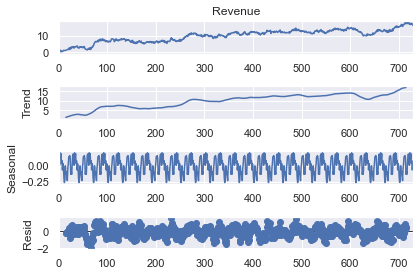

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=30)
decomposition.plot()


,Day,Revenue
1,1.0,0.000793
2,1.0,0.824749
3,1.0,-0.505210
4,1.0,0.762222
5,1.0,-0.974900


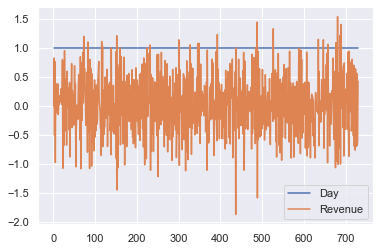

In [188]:
df_adj = df - df.shift(1)
df_adj.dropna(inplace=True)
df_adj.plot()
df_adj.head()


### Autocorrelation

0.9902917999411421
0.0724932187026203


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


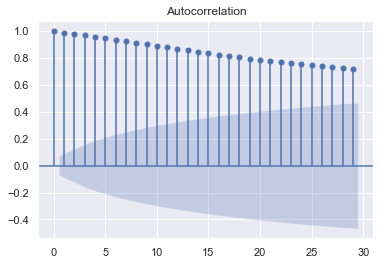

In [189]:
acf_array=acf(df['Revenue'])
autocorrelation = df['Revenue'].autocorr()
print(autocorrelation)
nobs = len(df['Revenue'])
confidence_inteveral = 1.96/np.sqrt(nobs)
print(confidence_inteveral)
plot_acf(df['Revenue'], alpha=.05)
plt.show()


### The autocorrelation is .99. This means that there is a very positive autocorrelation.

### Spectal Density

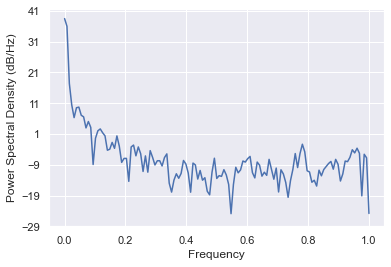

In [190]:
# Spectral Density Plot
plt.psd(df['Revenue'])
plt.show()


### Lack of trends in the residuals
Our charts above show that their are no obvious trends in the residuals.

### D.2. ARIMA Model

### Selection of ARIMA model

Through the use of auto_arima we are able to make quick work of finding the best ARIMA model for our data. Auto_arima searches for the best values to use and provides them after running.

In [191]:
auto_arima_model = auto_arima(df['Revenue'], start_p=0, d=None, start_q=0,
                   max_p=3, max_d=3, max_q=3, start_P=0,
                   D=1, start_Q=0, max_P=3, max_D=3,
                   max_Q=3, m=12, seasonal=True,
                   error_action='warn',trace = True,
                   supress_warnings=True, stepwise = True,
                   )


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2367.159, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1419.537, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1969.738, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2399.547, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1568.311, Time=0.07 sec


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1320.755, Time=1.41 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1289.226, Time=4.72 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=9.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=2340.010, Time=1.54 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=1114.506, Time=4.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1147.041, Time=2.50 sec
 ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=14.28 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(3,0,0)(3,1,0)[12] intercept   : AIC=1116.490, Time=6.02 sec


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(3,1,0)[12] intercept   : AIC=1116.494, Time=9.16 sec


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=1156.586, Time=6.24 sec


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(3,1,0)[12] intercept   : AIC=1118.299, Time=17.57 sec
 ARIMA(2,0,0)(3,1,0)[12]             : AIC=1114.884, Time=1.54 sec

Best model:  ARIMA(2,0,0)(3,1,0)[12] intercept
Total fit time: 87.855 seconds


In [192]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  731
Model:             SARIMAX(2, 0, 0)x(3, 1, 0, 12)   Log Likelihood                -550.253
Date:                            Mon, 17 Jan 2022   AIC                           1114.506
Time:                                    22:53:01   BIC                           1146.551
Sample:                                         0   HQIC                          1126.878
                                            - 731                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0315      0.022      1.460      0.144      -0.011       0.074
ar.L1          0.4873      0.033     14.885      0.000       0.423       0.551
ar.L2          0.4711      0.034     13.956      0.000       0.405       0.537
ar.S.L12      -0.7879      0.040    -19.836      0.000      -0.866      -0.710
ar.S.L24      -0.5436      0.047    -11.536      0.000      -0.636      -0.451
ar.S.L36      -0.2230      0.040     -5.508      0.000      -0.302      -0.144
sigma2         0.2667      0.015     17.689      0.000       0.237       0.296
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.96   Prob(JB):                         0.43
Heteroskedasticity (H):               1.11   Skew:                             0.01
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### D.3. Forecast with derived ARIMA model

Auto_arima has found the best values for the ARIMA model. 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69842D-01    |proj g|=  5.00982D-01

At iterate    5    f=  7.52792D-01    |proj g|=  3.49162D-01

At iterate   10    f=  7.21189D-01    |proj g|=  6.43983D-02

At iterate   15    f=  7.11867D-01    |proj g|=  9.42864D-03

At iterate   20    f=  7.11783D-01    |proj g|=  1.86292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   8.055D-06   7.118D-01
  F =  0.71178283376738227     

CONVERG

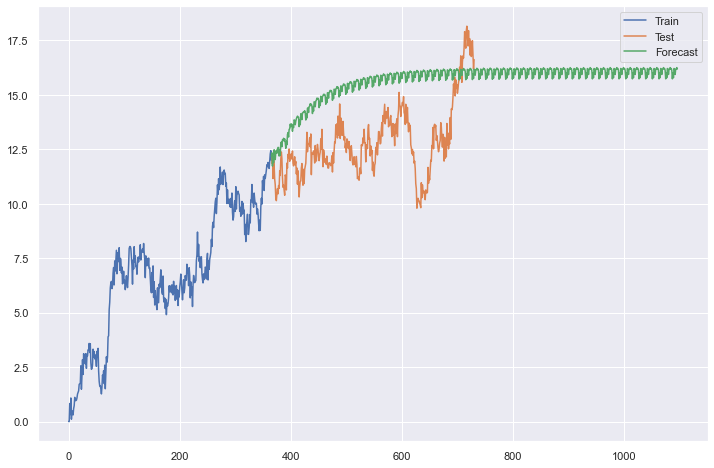

In [204]:
# Build SARIMAX model
model = SARIMAX(df_train['Revenue'], order=(2,0,0), seasonal_order=(3,1,0,12))

model = model.fit()

model.summary()

prediction = model.predict(start=365, end=731+365, dynamic=True)

# Plot the train and test data with forecast after test data
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_train['Revenue'], label='Train')
ax.plot(df_test['Revenue'], label='Test')
ax.plot(prediction,label='Forecast')
ax.legend()
plt.show()


## Part V: Data Summary and Implications

### E.1. Results

#### Arima Model

Using auto_arima we found the best values for the ARIMA model. Those values are: [2,0,0] and  [3,1,0,12].

#### Prediction Forecast Length

The prediction forecast length is set to 365 days. This provides a year's worth of predictions, that allows the company to make a better decision on how to plan for increased or decreased revenue in that time frame.

#### Justification for the forecast length

The provided data was two years in length. The data was then split into year-long training and test sets, and the model was trained on the training set. The model was then tested on the test set. The test set was used to predict the future values. The length of the test set was 12 months, which allowed us to make a better decision on how to plan for increased or decreased revenue in that time frame.

#### Model Evaluation and Error Metric

In [217]:
# RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_test['Revenue'], predictions))
# Print RMSE with "RMSE: "
print("RMSE: %f" % (rmse))



# MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(df_test['Revenue'], predictions)
print("MAPE: %f" % (mape))






RMSE: 3.407472
MAPE: 0.260646


MAPE is a measure of the percentage error between the actual and predicted values. The MAPE is calculated by taking the difference between the actual and predicted values, and dividing by the actual values. Our MAPE is .26 which implies that the model is around 74% accurate. While this accuracy is not great, it is still a viable model with some tweaking. 

### E.2. Annotated Visualizations

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


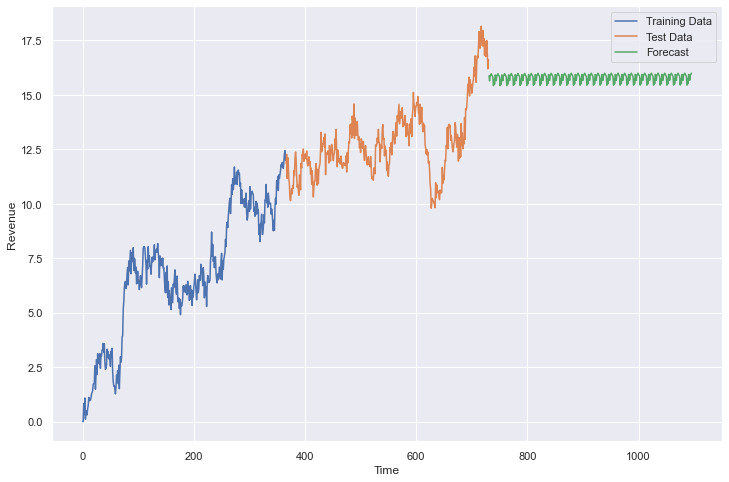

In [209]:
predictions = model.predict(start=731, end=1095, dynamic=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_train['Revenue'], label='Training Data')
ax.plot(df_test['Revenue'], label='Test Data')
ax.plot(predictions, label='Forecast')
ax.set(xlabel='Time', ylabel='Revenue')
ax.legend()
plt.show()

### E.3. Course of Action

The model while not perfect is able to predict future revenue that is in line with the past revenue. The model has some uncertainty, but follows an upward trend.

The best course of action would be to continue to refine the model with new data, this will allow the company to increase accuracy of the model moving forward. With more data the model will continue to improve in accuracy.

## Part VI: Reporting

### G. Code References

Pathak, P. (2020, October 29). How to create an Arima model for time series forecasting in python?at. Analytics Vidhya. Retrieved January 1, 2022, from https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/ 

Portilla, J. M. (2018, June 10). Using python and auto arima to forecast seasonal time series. Medium. Retrieved January 7, 2022, from https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c 

Prabhakaran, S. (2021, December 19). Arima model - complete guide to time series forecasting in python: ML+. Machine Learning Plus. Retrieved January 14, 2022, from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 

### H. References

BANERJEE, P. R. A. S. H. A. N. T. (2020, October 23). Arima model for time series forecastingvPRASHANT BANERJEE. Kaggle. Retrieved January 12, 2022, from https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting 

Pathak, P. (2020, October 29). How to create an Arima model for time series forecasting in python?at. Analytics Vidhya. Retrieved January 1, 2022, from https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/ 

Portilla, J. M. (2018, June 10). Using python and auto arima to forecast seasonal time series. Medium. Retrieved January 7, 2022, from https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c 

Prabhakaran, S. (2021, December 19). Arima model - complete guide to time series forecasting in python: ML+. Machine Learning Plus. Retrieved January 14, 2022, from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 